In [167]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.transforms import ToTensor

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
import torchvision
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import random
from random import sample
import seaborn as sns
import matplotlib.pyplot as plt

In [168]:
!rm -rf runs/*

In [169]:
tcga_tybalt_file_location = 'data/rescaled_minmax_tcga_df_sort.tsv.gz'

In [170]:
rnaseq_df = pd.read_table(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1,  inplace=True)
rnaseq_df = rnaseq_df.dropna()
print(rnaseq_df.shape)
rnaseq_df.head(2)

(9954, 4046)


,NUDT10,STOX2,TRIM10,SAA1,LRRC31,GRIN1,FAM72D,ATCAY,KCNT1,VSIG1,...,COL4A6,TCEAL5,LRIG1,GRM8,PKNOX2,FAM184A,SOD3,SPAG4,PCDHAC1,BAIAP2L2
0,0.010398,0.010045,0.000060,0.002066,0.001961,0.001141,0.057238,0.000037,0.000686,0.000108,...,0.008247,0.027951,0.050610,0.000566,0.002410,0.027414,0.007775,0.00690,0.009055,0.002555
1,0.002684,0.108628,0.000299,0.000007,0.053782,0.000321,0.011429,0.000064,0.010800,0.001179,...,0.002528,0.004978,0.067007,0.002910,0.011035,0.159884,0.020307,0.01578,0.028547,0.000908


In [171]:
test_set_percent = 0.1
rnaseq_df_test = rnaseq_df.sample(frac=test_set_percent)
rnaseq_df_train = rnaseq_df.drop(rnaseq_df_test.index)

In [172]:
# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data.iloc[idx].values, dtype=torch.float32)


In [174]:
train_dataset = CustomDataset(rnaseq_df_train)
test_dataset = CustomDataset(rnaseq_df_test)

In [175]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [176]:
class VAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: list, z_dim):
        super(VAE, self).__init__()
        
        self.z_dim = z_dim
        
        self.encoder_layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim[0])])
        self.decoder_layers = nn.ModuleList([nn.Linear(hidden_dim[0], input_dim)])
                
        if len(hidden_dim)>1:
            for i in range(len(hidden_dim)-1):
                self.encoder_layers.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
                self.decoder_layers.insert(0, nn.Linear(hidden_dim[i+1], hidden_dim[i]))
                
        self.encoder_layers.append(nn.Linear(hidden_dim[-1], 2 * z_dim))
        self.batchnorm = nn.BatchNorm1d(z_dim)
        self.decoder_layers.insert(0, nn.Linear(z_dim, hidden_dim[-1]))

        
    def encoder(self, x):
        for idx, layer in enumerate(self.encoder_layers):
            x = layer(x)
            if idx < len(self.encoder_layers) - 1:
                # x = F.dropout(x, 0.01)
                x = F.relu(x)
                #x = nn.BatchNorm1d(x)
        return x[...,:self.z_dim], x[...,self.z_dim:] # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        # std = torch.abs(log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        for idx, layer in enumerate(self.decoder_layers):
            z = layer(z)
            if idx < len(self.decoder_layers) - 1:
                # x = F.dropout(x, 0.01)
                z = F.relu(z)
        return torch.sigmoid(z) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, input_dim))
        mu = self.batchnorm(mu)
        log_var = self.batchnorm(log_var)
    #    z = self.sampling(mu, log_var)
        latent = MultivariateNormal(loc = mu, 
                                    scale_tril=torch.diag_embed(torch.exp(0.5*log_var)))
        z = latent.rsample()
           
    #    return self.decoder(z), mu, log_var
        return self.decoder(z), latent

    @staticmethod
    def loss_function(recon_x, x, mu, log_var):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return BCE + KLD
    
    @staticmethod
    def loss_function_dist(recon_x, x, latent, input_dim):
        prior = MultivariateNormal(loc = torch.zeros(latent.mean.shape[1]),
                                   scale_tril=torch.eye(latent.mean.shape[1]))
        
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction='sum')
        KLD = torch.sum(kl_divergence(latent, prior))
        return BCE + KLD

In [177]:
 def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        
        # Every data instance 
        data = data.to(DEVICE)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        recon_batch, latent = vae(data)

        # Compute the loss and its gradients
        loss = VAE.loss_function_dist(recon_batch, data, latent, input_dim)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100.0 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [178]:
# build model
input_dim=rnaseq_df.shape[1]
#vae = VAE(input_dim=input_dim, hidden_dim=[100,100], z_dim=100)
vae = VAE(input_dim=input_dim, hidden_dim=[100], z_dim=100)
# if torch.backends.mps.is_available():
#     DEVICE = 'mps'
# else:
#train_loader = torch.utils.data.DataLoader(dataset=torch.Tensor(torch.randn(30, 5000)), batch_size=100, shuffle=True)

DEVICE = 'cpu'
    
vae.to(DEVICE)

optimizer = optim.Adam(vae.parameters(), lr=0.0005)


# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/tcga_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 100

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    vae.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    vae.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs = vdata
        voutputs, latent = vae(vinputs)
        
        vloss = VAE.loss_function_dist(voutputs, vinputs, latent, input_dim)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        #torch.save(vae.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 100 loss: 84123.82306640624
LOSS train 84123.82306640624 valid 38080.43359375
EPOCH 2:
  batch 100 loss: 29908.2273046875
LOSS train 29908.2273046875 valid 34455.84765625
EPOCH 3:
  batch 100 loss: 28650.282265625
LOSS train 28650.282265625 valid 32537.115234375
EPOCH 4:
  batch 100 loss: 27797.6625
LOSS train 27797.6625 valid 32298.203125
EPOCH 5:
  batch 100 loss: 27258.82744140625
LOSS train 27258.82744140625 valid 31209.73828125
EPOCH 6:
  batch 100 loss: 26766.47763671875
LOSS train 26766.47763671875 valid 31094.056640625
EPOCH 7:
  batch 100 loss: 26374.91248046875
LOSS train 26374.91248046875 valid 31207.166015625
EPOCH 8:
  batch 100 loss: 26092.17234375
LOSS train 26092.17234375 valid 30304.94921875
EPOCH 9:
  batch 100 loss: 25714.285703125
LOSS train 25714.285703125 valid 29445.63671875
EPOCH 10:
  batch 100 loss: 25444.66044921875
LOSS train 25444.66044921875 valid 28533.595703125
EPOCH 11:
  batch 100 loss: 25214.77517578125
LOSS train 25214.77517578125 va

In [179]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor = vae.forward(torch.tensor(rnaseq_df_test.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct = pd.DataFrame(input_rnaseq_reconstruct_tensor.detach().numpy(), columns=rnaseq_df.columns)

In [180]:
reconstruction_fidelity = rnaseq_df - input_rnaseq_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_df.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
RBM47,0.008976,0.011756
OVOL2,0.016459,0.011373
TMC4,0.010250,0.010840
GRHL2,0.011151,0.010598
KLF5,0.002232,0.010547


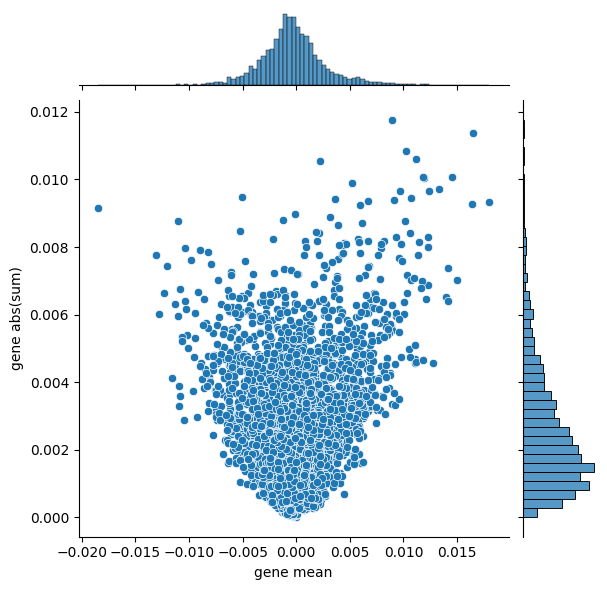

In [181]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary)

In [182]:
BCE_loss = []
KLD_loss = []
MSE_loss = []
# print row vectors next to each other in a loop
for i in range(len(rnaseq_df_test)):
    x = torch.Tensor(rnaseq_df_test.iloc[i].values)
    y= torch.Tensor(input_rnaseq_reconstruct.iloc[i].values)
    bce_loss = F.binary_cross_entropy(x, y)
    mse_loss = F.mse_loss(x,y)
    
    #prior = MultivariateNormal(loc = torch.zeros(model.forward(x)[1].mean.shape[1])
    #                           ,scale_tril=torch.eye(vae.forward(x)[1].mean.shape[1]))
    
    #kld_loss = torch.sum(kl_divergence(x, prior).item())
    BCE_loss.append(bce_loss)
    MSE_loss.append(mse_loss)
    

In [183]:
# Each row is shuffled randomly
def shuffle_random_subset_rows(df, subset_size):
    """
    Shuffles a random subset of each row of a Pandas DataFrame while keeping column names.
    """
    df_shuffled = df.copy()
    num_cols = len(df.columns)
    for i in range(len(df_shuffled)):
        subset_cols = np.random.choice(num_cols, subset_size, replace=False)
        df_shuffled.iloc[i, subset_cols] = np.random.permutation(df_shuffled.iloc[i, subset_cols])
    return df_shuffled


In [184]:
#1 percent of data shuffeled
rnaseq_df_1_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.01))

#3.0 percent of data shuffeled
rnaseq_df_3_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.05))

#5.0 percent of data shuffeled
rnaseq_df_5_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.10))

#8.0 percent of data shuffeled
rnaseq_df_8_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.30))

#10.0 percent of data shuffeled
rnaseq_df_10_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.50))

#20.0 percent of data shuffeled
rnaseq_df_20_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.80))

In [185]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_1_rs = vae.forward(torch.tensor(rnaseq_df_1_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_1_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_1_rs.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_3_rs = vae.forward(torch.tensor(rnaseq_df_3_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_3_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_3_rs.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_5_rs = vae.forward(torch.tensor(rnaseq_df_5_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_5_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_5_rs.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_8_rs = vae.forward(torch.tensor(rnaseq_df_8_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_8_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_8_rs.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_10_rs = vae.forward(torch.tensor(rnaseq_df_10_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_10_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_10_rs.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_20_rs = vae.forward(torch.tensor(rnaseq_df_20_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_20_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_20_rs.detach().numpy(), columns=rnaseq_df.columns)

In [186]:
#compute losses
def compute_losses(rnaseq_df, input_rnaseq_reconstruct):
    BCE_loss = []
    MSE_loss = []
    KLD_loss = []
    for i in range(len(rnaseq_df)):
        x = torch.Tensor(rnaseq_df.iloc[i].values)
        y= torch.Tensor(input_rnaseq_reconstruct.iloc[i].values)
        bce_loss = F.binary_cross_entropy(x, y)
        mse_loss = F.mse_loss(x,y)

        #prior = MultivariateNormal(loc = torch.zeros(model.forward(x)[1].mean.shape[1])
        #                           ,scale_tril=torch.eye(vae.forward(x)[1].mean.shape[1]))

        #kld_loss = torch.sum(kl_divergence(x, prior).item())
        BCE_loss.append(bce_loss.numpy().item())
        MSE_loss.append(mse_loss.numpy().item())
        
    return BCE_loss, MSE_loss

In [187]:
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct)[0]))
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_1_rs)[0]))
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_5_rs)[0]))
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_8_rs)[0]))
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_10_rs)[0]))
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_20_rs)[0]))

0.12401044514011499
0.14682042503626502
0.1464112309954274
0.1465850979838539
0.14752757545541878
0.14864278256743396


In [188]:
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct)[1]))
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_1_rs)[1]))
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_5_rs)[1]))
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_8_rs)[1]))
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_10_rs)[1]))
print(np.mean(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_20_rs)[1]))

0.0018078081770484154
0.0030495774563654657
0.0029677188760441862
0.0028492362404022196
0.0028123697705318843
0.002782679062942745


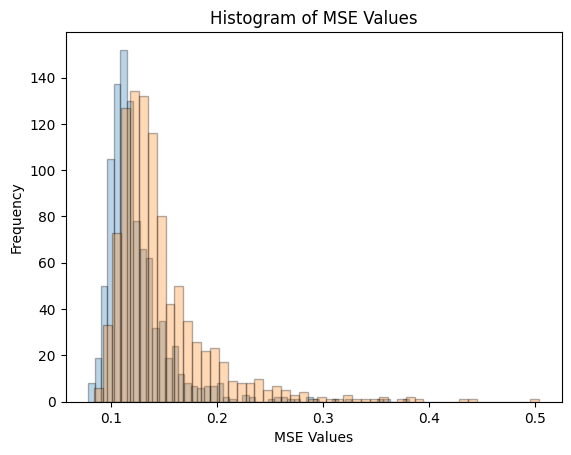

In [189]:
# Sample list of Mean Squared Error (MSE) values


# Create a histogram plot for MSE values
plt.hist(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.3)
plt.hist(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_1_rs)[0], bins=50, edgecolor='black', alpha=0.3)
plt.xlabel('MSE Values')
plt.ylabel('Frequency')
plt.title('Histogram of MSE Values')

# Show the plot
plt.show()

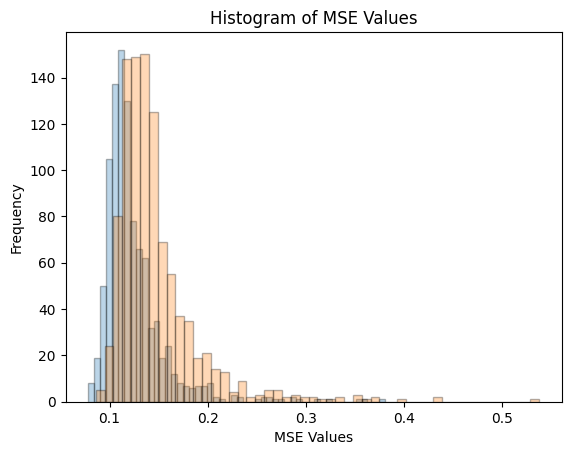

In [190]:
# Sample list of Mean Squared Error (MSE) values


# Create a histogram plot for MSE values
plt.hist(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.3)
plt.hist(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_10_rs)[0], bins=50, edgecolor='black', alpha=0.3)
plt.xlabel('MSE Values')
plt.ylabel('Frequency')
plt.title('Histogram of MSE Values')

# Show the plot
plt.show()

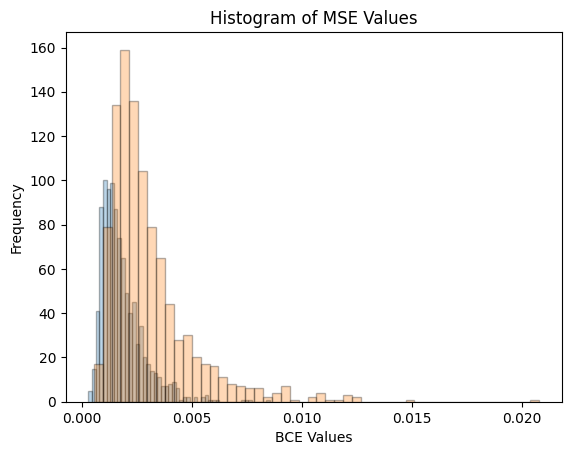

In [191]:
# Sample list of Mean Squared Error (MSE) values


# Create a histogram plot for MSE values
plt.hist(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.3)
plt.hist(compute_losses(rnaseq_df_test, input_rnaseq_reconstruct_df_1_rs)[1], bins=50, edgecolor='black', alpha=0.3)
plt.xlabel('BCE Values')
plt.ylabel('Frequency')
plt.title('Histogram of MSE Values')

# Show the plot
plt.show()

In [192]:
F.binary_cross_entropy(torch.Tensor([0,0,0,0]), torch.Tensor([1,1,1,1]))

tensor(100.)

In [193]:
gtex_file_location = 'data/rescaled_minmax_gtex_df_sort.tsv.gz'

In [194]:
gtex_df = pd.read_table(gtex_file_location)

In [195]:
gtex_df_dataset = CustomDataset(target_df)

In [196]:
validation_loader_gtex = torch.utils.data.DataLoader(dataset=gtex_df_dataset, batch_size=50, shuffle=False)

In [197]:
gtex_df.head(3)

,Unnamed: 0,NUDT10,STOX2,TRIM10,SAA1,LRRC31,GRIN1,FAM72D,ATCAY,KCNT1,...,COL4A6,TCEAL5,LRIG1,GRM8,PKNOX2,FAM184A,SOD3,SPAG4,PCDHAC1,BAIAP2L2
0,0,0.010769,0.016115,0.067705,0.000003,0.000385,0.000008,0.001724,0.000083,0.000073,...,0.002783,0.000271,0.008541,0.003669,0.019206,0.049302,0.030613,0.035231,0.000000,0.359042
1,1,0.001487,0.068504,0.000190,0.000034,0.000351,0.000414,0.001177,0.000413,0.000626,...,0.000220,0.000409,0.116403,0.001947,0.043968,0.032093,0.018290,0.191538,0.061562,0.007165
2,2,0.000897,0.025564,0.000000,0.000035,0.000000,0.000069,0.000000,0.001183,0.029000,...,0.000248,0.000184,0.076454,0.000000,0.098413,0.005837,0.001239,0.002138,0.000000,0.001322


In [198]:
gtex_df = gtex_df.drop(columns=gtex_df.columns[0])

In [199]:
# How well does the model reconstruct the input RNAseq data
input_gtex_reconstruct_tensor = vae.forward(torch.tensor(gtex_df.values, dtype=torch.float32))[0]
input_gtex_reconstruct = pd.DataFrame(input_gtex_reconstruct_tensor.detach().numpy(), columns=gtex_df.columns)

In [200]:
reconstruction_fidelity_gtex = gtex_df - input_gtex_reconstruct

gene_mean = reconstruction_fidelity_gtex.mean(axis=0)
gene_abssum = reconstruction_fidelity_gtex.abs().sum(axis=0).divide(rnaseq_df.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
RPS28,0.220465,0.233035
EDA,0.162852,0.173157
PCDHGA9,0.157946,0.167246
PHYHD1,0.144606,0.156750
CENPV,0.143459,0.153226


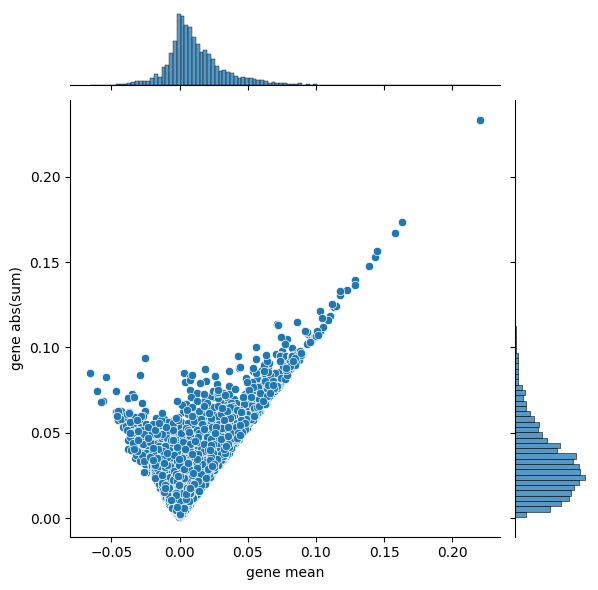

In [201]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary)

In [204]:
# build model
input_dim=rnaseq_df.shape[1]


#vae = VAE(input_dim=input_dim, hidden_dim=[100,100], z_dim=100)
vae_2 = VAE(input_dim=input_dim, hidden_dim=[100], z_dim=100)
# if torch.backends.mps.is_available():
#     DEVICE = 'mps'
# else:
#train_loader = torch.utils.data.DataLoader(dataset=torch.Tensor(torch.randn(30, 5000)), batch_size=100, shuffle=True)

# Freeze the decoder parameters
# Freeze the encoder part
for layer in vae.encoder_layers:
    for param in layer.parameters():
        param.requires_grad = False

DEVICE = 'cpu'
    
vae_2.to(DEVICE)

optimizer = optim.Adam(vae_2.parameters(), lr=0.0005)


# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/tcga_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 100

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    vae_2.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    vae_2.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs = vdata
        voutputs, latent = vae_2(vinputs)
        
        vloss = VAE.loss_function_dist(voutputs, vinputs, latent, input_dim)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        #torch.save(vae.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 100 loss: 23311.91537109375
LOSS train 23311.91537109375 valid 175778.3125
EPOCH 2:
  batch 100 loss: 23336.043125
LOSS train 23336.043125 valid 175765.265625
EPOCH 3:
  batch 100 loss: 23325.0691015625
LOSS train 23325.0691015625 valid 175755.578125
EPOCH 4:
  batch 100 loss: 23304.4685546875
LOSS train 23304.4685546875 valid 175754.140625
EPOCH 5:
  batch 100 loss: 23278.29599609375
LOSS train 23278.29599609375 valid 175741.46875
EPOCH 6:
  batch 100 loss: 23287.375078125
LOSS train 23287.375078125 valid 175787.8125
EPOCH 7:
  batch 100 loss: 23331.67158203125
LOSS train 23331.67158203125 valid 175764.84375
EPOCH 8:
  batch 100 loss: 23307.3908984375
LOSS train 23307.3908984375 valid 175763.609375
EPOCH 9:
  batch 100 loss: 23323.301640625
LOSS train 23323.301640625 valid 175759.671875
EPOCH 10:
  batch 100 loss: 23288.94236328125
LOSS train 23288.94236328125 valid 175776.9375
EPOCH 11:
  batch 100 loss: 23297.49166015625
LOSS train 23297.49166015625 valid 175782.171